# Example Notebook for use of CosMomentum
## Table of contents:

- Section 1: initialising a universe and its matter content
- Section 2: computing the PDF of matter density fluctuations
- Section 3: computing the cumulant generating function and individual connected moments
- Section 4: creating galaxy samples and computing their counts-in-cells PDF 

In [1]:
# loading required packages
import ctypes
import sys
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# compiling and loading c++ library
os.system("cd cpp_code; make DSS")
lib=ctypes.CDLL("./cpp_code/DSS.so")

# Section 1: initialising a universe and its matter content

In [3]:
# initialising a new universe and its matter content
a_initial = 0.000025
a_final = 1.01

initialise_new_Universe_with_Matter_content = lib.initialise_new_Universe_with_Matter_content
# initialise_new_Universe_with_Matter_content          (double a_initial,  double a_final,  double Omega_m,  double Omega_b,  double Omega_r,  double Omega_L,  double sigma_8,      double n_s,    double h_100,       double w0,       double w1)
initialise_new_Universe_with_Matter_content.argtypes = [ ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double]
initialise_new_Universe_with_Matter_content.restype = None

# Cosmology of Quijote sims
Omfid = 0.3175
Obfid = 0.049
hfid = 0.6711
nsfid = 0.9624
sig8fid = 0.834

z = 1.0 # everywhere in this notebook

initialise_new_Universe_with_Matter_content(a_initial, a_final, Omfid, Obfid, 0.0, 1.0-Omfid, sig8fid, nsfid, hfid, -1.0, 0.0)


### Computing the skewness of the linear density field
### Defining $\epsilon_3(R) \equiv <\delta_R^3>/\sigma_R^2$ the function set_primordial_skewness_from_eps3_powerlaw_approximation assumed that $\epsilon_3(R) \approx A_{\epsilon_3}*(R/R_0)^{n_{\epsilon_3}}$ and computes $A_{\epsilon_3}$ and $n_{\epsilon_3}$ at $R = R_0$.
### Alternatively, see also set_primordial_skewness and set_primordial_skewness_from_file in python_interfaces.cpp

In [4]:
# Computing the skewness of the linear density field
# Defining eps_3(R) == <\delta_R^3>/\sigma_R^2 the function set_primordial_skewness_from_eps3_powerlaw_approximation assumed that eps_3(R) \approx A_eps3*(R/R_0)^n_eps3 and computes A_eps3 and n_eps3 at R = R_0.
# Alternatively, see also set_primordial_skewness and set_primordial_skewness_from_file in python_interfaces.cpp

set_primordial_skewness_from_eps3_powerlaw_approximation = lib.set_primordial_skewness_from_eps3_powerlaw_approximation
# set_primordial_skewness_from_eps3_powerlaw_approximation          (int index_of_universe, int PNG_modus, double R_0_in_Mpc_over_h)
set_primordial_skewness_from_eps3_powerlaw_approximation.argtypes = [           ctypes.c_int,  ctypes.c_int,          ctypes.c_double]
set_primordial_skewness_from_eps3_powerlaw_approximation.restype = None

set_primordial_skewness_from_eps3_powerlaw_approximation(0, 1, 15.0)

# Section 2: computing the PDF of matter density fluctuations

In [5]:

# N_delta has to be hardcoded, because is it needed for defining the python-c++ interface
N_delta = 400
delta_min = -0.7
delta_max = 1.0

return_PDF = lib.return_PDF
# return_PDF          (                   double* delta_values,                                      double* PDF,  int n_delta, double delta_min, double delta_max,        double z, double R_in_comoving_Mpc,     double f_NL, double var_NL_rescale, int index_of_universe)
return_PDF.argtypes = [ctypes.POINTER(ctypes.c_double*N_delta),          ctypes.POINTER(ctypes.c_double*N_delta), ctypes.c_int,  ctypes.c_double,  ctypes.c_double, ctypes.c_double,          ctypes.c_double, ctypes.c_double,       ctypes.c_double,          ctypes.c_int]
return_PDF.restype = None

## This function returns the probability distribution function (PDF) of the 3D matter density field
# - at redshift z
# - top-hat smoothing radius R [Mpc/h]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for universe index_of_universe (= 0 if you have only created one universe
def PDF_from_inv_Laplace_transform(z, R, f_NL, var_NL_rescale, index_of_universe):
    delta_values     = (ctypes.c_double*N_delta)()
    PDF_values       = (ctypes.c_double*N_delta)()
    return_PDF(ctypes.byref(delta_values), ctypes.byref(PDF_values),N_delta, delta_min, delta_max , z, R, f_NL, var_NL_rescale, index_of_universe)
    return np.array(delta_values), np.array(PDF_values)



return_Nlambda = lib.return_Nlambda
return_Nlambda.argtypes = [ctypes.c_int]
return_Nlambda.restype = ctypes.c_int
N_lambda = return_Nlambda(0)

return_CGF = lib.return_CGF
#           return_CGF(                         double* delta_L,                         double* delta_NL,                           double* lambda,                              double* phi,                     double* lambda_Gauss,                        double* phi_Gauss,                        double* variances,                       double* skewnesses,                              double* R_L,        double z, double R_in_comoving_Mpc,     double f_NL, double var_NL_rescale, int index_of_universe)
return_CGF.argtypes = [ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.c_double,          ctypes.c_double, ctypes.c_double,       ctypes.c_double,          ctypes.c_int]
return_CGF.restype = None

## This function returns the cumulant generating function (CGF) of the 3D matter density field
# - at redshift z
# - top-hat smoothing radius R [Mpc/h]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for universe index_of_universe (= 0 if you have only created one universe)
def CGF(z, R, f_NL, var_NL_rescale, index_of_universe):
    delta_L_values        = (ctypes.c_double*N_lambda)()
    delta_NL_values       = (ctypes.c_double*N_lambda)()
    lambda_values         = (ctypes.c_double*N_lambda)()
    phi_values            = (ctypes.c_double*N_lambda)()
    lambda_values_Gauss   = (ctypes.c_double*N_lambda)()
    phi_values_Gauss      = (ctypes.c_double*N_lambda)()
    variances             = (ctypes.c_double*N_lambda)()
    skewnesses            = (ctypes.c_double*N_lambda)()
    R_L_values            = (ctypes.c_double*N_lambda)()
    
    return_CGF(ctypes.byref(delta_L_values), ctypes.byref(delta_NL_values), ctypes.byref(lambda_values), ctypes.byref(phi_values), ctypes.byref(lambda_values_Gauss), ctypes.byref(phi_values_Gauss), ctypes.byref(variances), ctypes.byref(skewnesses), ctypes.byref(R_L_values), z, R, f_NL, var_NL_rescale, index_of_universe)
    return np.array(delta_L_values), np.array(delta_NL_values), np.array(lambda_values), np.array(phi_values), np.array(lambda_values_Gauss), np.array(phi_values_Gauss), np.array(variances), np.array(skewnesses), np.array(R_L_values)

## This function returns the PDF of the 3D matter density field using a saddle point
## approximation to solve the inverse Laplace transform that relates PDF and CGF.
# - at redshift z
# - top-hat smoothing radius R [Mpc/h]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for universe index_of_universe (= 0 if you have only created one universe
def PDF_from_saddlepoint(z, R, f_NL, var_NL_rescale, index_of_universe):
    d_L, d_NL, l, phi, l_G, phi_G, var, skew, R_L = CGF(z, R, f_NL, var_NL_rescale, index_of_universe)
    Nl = len(l)
    l_plus   = l[1:]
    l_minus  = l[:Nl-1]
    l_center = 0.5*(l_plus+l_minus)
    d_NL_plus  = d_NL[1:]
    d_NL_minus = d_NL[:Nl-1]
    d_NL_center = 0.5*(d_NL_plus+d_NL_minus)
    d_NL_prime = (d_NL_plus-d_NL_minus)/(l_plus-l_minus)
    ddelta = (delta_max-delta_min)/float(N_delta-1)
    delta_values     = np.arange(0, N_delta)*ddelta+delta_min
    PDF_values       = np.zeros(N_delta)
    phi_interp = np.interp(delta_values, d_NL, phi)
    phi_prime_prime_interp = np.interp(delta_values, d_NL_center, d_NL_prime)
    l_interp = np.interp(delta_values, d_NL, l)
    indeces = np.where(phi_prime_prime_interp>0.0)[0]
    PDF_values[indeces]       = np.exp(-l_interp[indeces]*delta_values[indeces]+phi_interp[indeces])/np.sqrt(2.0*np.pi*phi_prime_prime_interp[indeces])
    return delta_values, PDF_values

In [6]:
# PDF from full inverse Laplace transform of the cumulant generating function
# assuming f_NL = 0.0
delta_values, PDF_values = PDF_from_inv_Laplace_transform(z, 15.0, 0.0, 1.0, 0)

In [7]:
# PDF from full inverse Laplace transform of the cumulant generating function
# assuming f_NL = 100.0
delta_values, PDF_values_PNG = PDF_from_inv_Laplace_transform(z, 15.0, 100.0, 1.0, 0)

In [8]:
# PDF from saddle point approximation of inverse Laplace transform
# assuming f_NL = 0.0
delta_values, PDF_values_saddle_point_approx = PDF_from_saddlepoint(z, 15.0, 0.0, 1.0, 0)

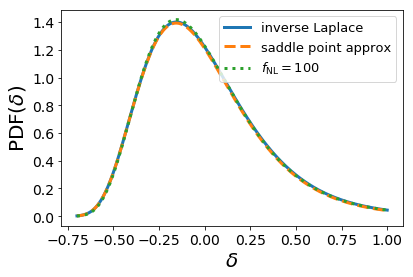

In [9]:
plt.plot(delta_values, PDF_values, linewidth=3, linestyle='solid', label='inverse Laplace')
plt.plot(delta_values, PDF_values_saddle_point_approx, linewidth=3, linestyle='dashed', label='saddle point approx')
plt.plot(delta_values, PDF_values_PNG, linewidth=3, linestyle='dotted', label=r'$f_{\mathrm{NL}} = 100$')


plt.legend(fontsize=13, loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel(r'$\delta$', size = 20)
plt.ylabel(r'$\mathrm{PDF}(\delta)$', size = 20)
plt.subplots_adjust(left  = 0.18, right = 0.97, bottom=0.17, top=0.92)

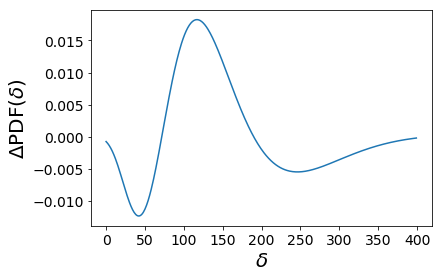

In [21]:
plt.plot(PDF_values_PNG-PDF_values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel(r'$\delta$', size = 20)
plt.ylabel(r'$\Delta\mathrm{PDF}(\delta)$', size = 20)
plt.subplots_adjust(left  = 0.18, right = 0.97, bottom=0.17, top=0.92)

# Section 3: computing the cumulant generating function and individual connected moments

## See sections 2.1 and 4.6 of https://arxiv.org/abs/1912.06621 for details

In [11]:

# This is code for extracting individual moments from the CGF (see section 4.6 of https://arxiv.org/abs/1912.06621):

def factoria(n):
    fact = np.ones(n+1)
    for i in range(1, n+1):
        fact[i] = fact[i-1]*float(i)
    return fact

def Bell_polynomial(n, k, x, fact):
    n = int(n+0.1)
    k = int(k+0.1)
    
    if n == 0 and k == 0:
        return 1.0
    if n == 0 and k != 0:
        return 0.0
    if n != 0 and k == 0:
        return 0.0
    
    sum = 0.0
    
    for i in range(1, n-k+2):
        binomial = fact[n-1]/fact[n-i]/fact[i-1]
        sum += x[i]*binomial*Bell_polynomial(n-i, k-1, x, fact)
    
    return sum


def return_Bell_matrix(lambda_coeffs_wrt_tau):
    n = len(lambda_coeffs_wrt_tau)
    fact = factoria(n)
    x = np.zeros(n);
    Bell_matrix = np.zeros((n,n))
    inverse_Bell_matrix = np.zeros((n,n))
    
    for i in range(0, n):
        x[i] = lambda_coeffs_wrt_tau[i]*fact[i];
        
    for i in range(0, n):
        for j in range(0, i+1):
            Bell_matrix[i,j] = Bell_polynomial(i, j, x, fact)
            
    inverse_Bell_matrix = np.linalg.inv(np.matrix(Bell_matrix))
    return inverse_Bell_matrix, Bell_matrix


def find_moments(lambda_values, phi_values, phi_prime_values, tau_values, R_L_values, R_min, R_max, degree):
    n = len(lambda_values)
    indices = np.where(lambda_values[1:] > lambda_values[:n-1])[0]
    
    lambda_max = lambda_values[0]
    check = 1
    n_cut = 0
    for i in range(1,n):
        if lambda_values[i] > lambda_max and check == 1:
            lambda_max = lambda_values[i]
            n_cut = i
        else:
            check = 0
    
    lambda_cut    = lambda_values[:n_cut]
    phi_cut       = phi_values[:n_cut]
    phi_prime_cut = phi_prime_values[:n_cut]
    tau_cut       = tau_values[:n_cut]
    R_cut         = R_L_values[:n_cut]
    
    tau_max = np.max(tau_cut)*0.9
    tau_min = np.min(tau_cut)*0.9
    #tau_min = -tau_max
    
    if R_cut[n_cut-1] > R_max:
        tau_max = np.min([tau_max, np.interp(R_max, R_cut, tau_cut)])
    if R_cut[0] < R_min:
        tau_min = np.max[tau_min, np.interp(R_min, R_cut, tau_cut)]
    
    #tau_max = np.min([tau_max, -tau_min])
    #tau_min = -tau_max
    
    N_tau = 8*degree+1
    tau_support_points = np.zeros(N_tau)
    dtau = -tau_min/float(N_tau/2)
    tau_support_points[:N_tau/2] = np.arange(tau_min, 0.0-0.5*dtau, dtau)
    tau_support_points[N_tau/2] = 0.0
    dtau = tau_max/float(N_tau/2)
    tau_support_points[N_tau/2+1:] = np.arange(0.0, tau_max-0.5*dtau, tau_max/float(N_tau/2))+tau_max/float(N_tau/2)
    phi_prime_points = np.interp(tau_support_points, tau_cut, phi_prime_cut)
    lambda_support_points = np.interp(tau_support_points, tau_cut, lambda_cut)
    
    delta_NL_coeffs_wrt_tau =  np.polyfit(tau_support_points, phi_prime_points, degree)
    delta_NL_coeffs_wrt_tau = np.flip(delta_NL_coeffs_wrt_tau)
    lambda_coeffs_wrt_tau =  np.polyfit(tau_support_points, lambda_support_points, degree)
    lambda_coeffs_wrt_tau = np.flip(lambda_coeffs_wrt_tau)
    
    inverse_Bell_matrix, Bell_matrix = return_Bell_matrix(lambda_coeffs_wrt_tau)
    
    delta_NL_coeffs_wrt_lambda = np.zeros(degree+1)
    fact = factoria(degree+1)
    
    for i in range(0, degree+1):
        for j in range(0, i+1):
            delta_NL_coeffs_wrt_lambda[i] += inverse_Bell_matrix[i,j]*delta_NL_coeffs_wrt_tau[j]*fact[j]
        #delta_NL_coeffs_wrt_lambda[i] /= fact[i]
    
    for i in range(degree, 0, -1):
        delta_NL_coeffs_wrt_lambda[i] = delta_NL_coeffs_wrt_lambda[i-1]#/float(i);
    delta_NL_coeffs_wrt_lambda[i] = 0.0
    
    return delta_NL_coeffs_wrt_lambda

In [12]:
var_NL_rescale = 1.0
f_NL = 3.0
R = 15.0

d_L_values, d_NL_values, lambda_values, phi_values, lambda_G_values, phi_G_values, var_lin_values, skew_lin_values, R_L_values = CGF(z, R, f_NL, var_NL_rescale, 0)
tau_values = d_L_values/var_lin_values

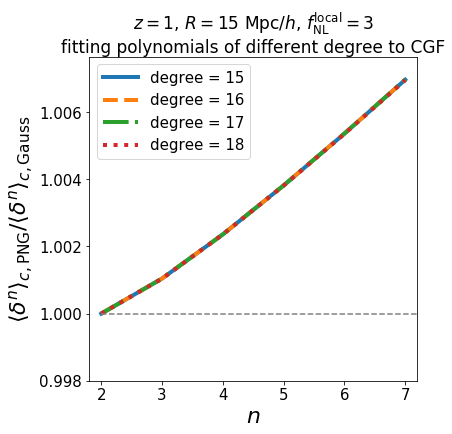

In [13]:

n_max = 8
plt.figure(figsize=(6,6))

moments_G = find_moments(lambda_G_values, phi_G_values, d_NL_values, tau_values, R_L_values, 5.0, 45.0, 15)
moments_PNG = find_moments(lambda_values, phi_values, d_NL_values, tau_values, R_L_values, 5.0, 45.0, 15)
plt.plot(range(2, n_max), moments_PNG[2:n_max]/moments_G[2:n_max], label='degree = 15', linewidth=4, linestyle='-')


moments_G = find_moments(lambda_G_values, phi_G_values, d_NL_values, tau_values, R_L_values, 5.0, 45.0, 16)
moments_PNG = find_moments(lambda_values, phi_values, d_NL_values, tau_values, R_L_values, 5.0, 45.0, 16)
plt.plot(range(2, n_max), moments_PNG[2:n_max]/moments_G[2:n_max], label='degree = 16', linewidth=4, linestyle='--')


moments_G = find_moments(lambda_G_values, phi_G_values, d_NL_values, tau_values, R_L_values, 5.0, 45.0, 17)
moments_PNG = find_moments(lambda_values, phi_values, d_NL_values, tau_values, R_L_values, 5.0, 45.0, 17)
plt.plot(range(2, n_max), moments_PNG[2:n_max]/moments_G[2:n_max], label='degree = 17', linewidth=4, linestyle='-.')


moments_G = find_moments(lambda_G_values, phi_G_values, d_NL_values, tau_values, R_L_values, 5.0, 45.0, 18)
moments_PNG = find_moments(lambda_values, phi_values, d_NL_values, tau_values, R_L_values, 5.0, 45.0, 18)
plt.plot(range(2, n_max), moments_PNG[2:n_max]/moments_G[2:n_max], label='degree = 18', linewidth=4, linestyle='dotted')


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(range(2, n_max+1), np.ones(n_max-1), linestyle='dashed', color='grey')
plt.xlim(1.8, n_max-0.8)
plt.ylim(0.998, 1.0 + 1.1*(moments_PNG[n_max-1]/moments_G[n_max-1]-1.0))
plt.legend(fontsize=15, handlelength=2.35)
plt.title('$z=1$, $R=15$ Mpc$/h$, '+r'$f_{\mathrm{NL}}^{\mathrm{local}} = 3$'+'\nfitting polynomials of different degree to CGF', size = 17)
plt.xlabel(r'$n$', size = 22)
plt.ylabel(r'$\langle \delta^n \rangle_{c,\mathrm{PNG}}/\langle \delta^n \rangle_{c,\mathrm{Gauss}}$', size = 22)
plt.subplots_adjust(left=0.19, bottom=0.12, right=0.95, top=0.87)

# Section 4: creating galaxy samples and computing their counts-in-cells PDF

## This part uses the bias and shot-noise model described in section IV.C.2 of https://arxiv.org/abs/1710.05162 .

In [14]:

add_galaxy_sample = lib.add_galaxy_sample
# add_galaxy_sample          (int index_of_universe,        double z, double density_in_Mpc_over_h_cubed,        double b1,        double b2,       double a0,       double a1)
add_galaxy_sample.argtypes = [         ctypes.c_int, ctypes.c_double,                    ctypes.c_double,  ctypes.c_double,  ctypes.c_double, ctypes.c_double, ctypes.c_double]
add_galaxy_sample.restype = None


return_N_max = lib.return_N_max
# int return_N_max      (int index_of_galaxy_sample,        double z, double R_in_Mpc_over_h)
return_N_max.argtypes = [              ctypes.c_int, ctypes.c_double,        ctypes.c_double]
return_N_max.restype = ctypes.c_int


change_parameters_of_galaxy_sample = lib.change_parameters_of_galaxy_sample
# change_parameters_of_galaxy_sample          (int index_of_galaxy_sample,        double z, double density_in_Mpc_over_h_cubed,        double b1,        double b2,       double a0,       double a1)
change_parameters_of_galaxy_sample.argtypes = [              ctypes.c_int, ctypes.c_double,                    ctypes.c_double,  ctypes.c_double,  ctypes.c_double, ctypes.c_double, ctypes.c_double]
change_parameters_of_galaxy_sample.restype = None

change_b2_to_minimise_negative_densities = lib.change_b2_to_minimise_negative_densities
# change_b2_to_minimise_negative_densities          (int index_of_galaxy_sample,        double z, double R_in_Mpc_over_h)
change_b2_to_minimise_negative_densities.argtypes = [              ctypes.c_int, ctypes.c_double,        ctypes.c_double]
change_b2_to_minimise_negative_densities.restype = ctypes.c_double


In [15]:
# Creating first galaxy sample
density_sample_1 = 0.002
b1_sample_1 = 1.6
b2_sample_1 = 0.0
a0 = 1.26
a1 = 0.29
add_galaxy_sample(0, z, density_sample_1, b1_sample_1, b2_sample_1, a0, a1)
# Changing parameters first galaxy sample
density_sample_1 = 0.001
change_parameters_of_galaxy_sample(0, z, density_sample_1, b1_sample_1, b2_sample_1, a0, a1)

In [16]:
# Creating second galaxy sample
density_sample_2 = 0.002
b1_sample_2 = 1.3
b2_sample_2 = 0.0
a0 = 1.4
a1 = 0.5
add_galaxy_sample(0, z, density_sample_2, b1_sample_2, b2_sample_2, a0, a1)

In [17]:
# Creating 3rd & 4th galaxy sample
density_sample_3 = 0.0005
b1_sample_3 = 2.1
b2_sample_3 = 0.0
a0 = 1.26
a1 = 0.29
add_galaxy_sample(0, z, density_sample_3, b1_sample_3, b2_sample_3, a0, a1)
add_galaxy_sample(0, z, density_sample_3, b1_sample_3, b2_sample_3, a0, a1)
# Changing b2 in 4th sample to minimise occurence of delta_g < -1
R = 20.0
b2_sample_4 = change_b2_to_minimise_negative_densities(3, z, R)

In [18]:

# Up to what N are the CiC histograms going to be computed? (needed for allocation of arrays in python-C++ interface)
R = 20.0
N_max = np.max([return_N_max(0, z, R), return_N_max(1, z, R), return_N_max(2, z, R), return_N_max(3, z, R)])
print N_max

return_CiC_PDF = lib.return_CiC_PDF
#           return_CiC_PDF(                       double* P_of_N,        double z, double R_in_Mpc_over_h,     double f_NL, double var_NL_rescale, int index_of_galaxy_sample)
return_CiC_PDF.argtypes = [ctypes.POINTER(ctypes.c_double*N_max), ctypes.c_double,        ctypes.c_double, ctypes.c_double,       ctypes.c_double,               ctypes.c_int]
return_CiC_PDF.restype = None

## This function returns the count-in-cells PDF of a 3D galaxy field
# - at redshift z
# - top-hat smoothing radius R [Mpc/h]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for galaxy sample index_of_galaxy_sample (= 0 if you have only created one galaxy sample)
def CiC(z, R, f_NL, var_NL_rescale, index_of_galaxy_sample):
    P_of_N_values        = (ctypes.c_double*N_max)()
    return_CiC_PDF(ctypes.byref(P_of_N_values), z, R, f_NL, var_NL_rescale, index_of_galaxy_sample)
    return np.array(P_of_N_values)



327


In [19]:
# computing CiC PDF for each sample
P_of_N_values_sample_1 = CiC(z, R, 0.0, 1.0, 0)
P_of_N_values_sample_2 = CiC(z, R, 0.0, 1.0, 1)
P_of_N_values_sample_3 = CiC(z, R, 0.0, 1.0, 2)
P_of_N_values_sample_4 = CiC(z, R, 0.0, 1.0, 3)

1.0000746721088882
1.0000746712465822
1.000074672108888
1.000074672108888


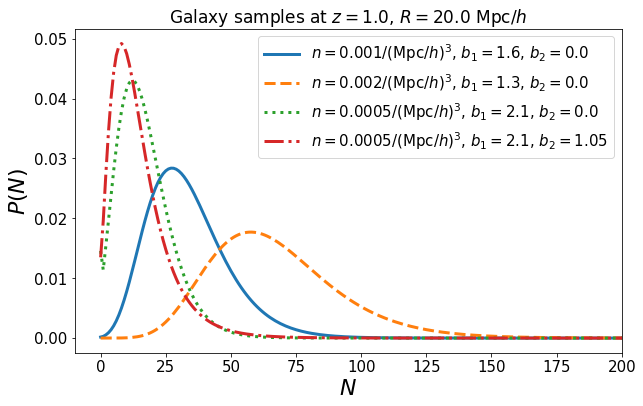

In [20]:
# plotting CiC PDF for each sample
plt.figure(figsize=(10,6))
plt.plot(range(0,N_max), P_of_N_values_sample_1, label="$n=$"+str(density_sample_1)+"/$($Mpc$/h)^3$, $b_1=$"+str(b1_sample_1)+", $b_2=$"+str(b2_sample_1), linestyle="solid", linewidth=3)
plt.plot(range(0,N_max), P_of_N_values_sample_2, label="$n=$"+str(density_sample_2)+"/$($Mpc$/h)^3$, $b_1=$"+str(b1_sample_2)+", $b_2=$"+str(b2_sample_2), linestyle="dashed", linewidth=3)
plt.plot(range(0,N_max), P_of_N_values_sample_3, label="$n=$"+str(density_sample_3)+"/$($Mpc$/h)^3$, $b_1=$"+str(b1_sample_3)+", $b_2=$"+str(b2_sample_3), linestyle="dotted", linewidth=3)
plt.plot(range(0,N_max), P_of_N_values_sample_4, label="$n=$"+str(density_sample_3)+"/$($Mpc$/h)^3$, $b_1=$"+str(b1_sample_3)+", $b_2=$"+str(b2_sample_4), linestyle="-.", linewidth=3)
plt.xlim(-10,200)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$N$', size = 22)
plt.ylabel(r'$P(N)$', size = 22)
plt.legend(fontsize=15, handlelength=2.35)
plt.title('Galaxy samples at $z=$'+str(z)+', $R=$'+str(R)+' Mpc$/h$', size = 17)
plt.subplots_adjust(left=0.19, bottom=0.12, right=0.95, top=0.87)

# check normalisation of the CiC PDFs
print np.sum(P_of_N_values_sample_1)
print np.sum(P_of_N_values_sample_2)
print np.sum(P_of_N_values_sample_3)
print np.sum(P_of_N_values_sample_4)